# Selecting number of heads on Slide-tags Data

- Data: [Russell, Andrew JC, et al. "Slide-tags enables single-nucleus barcoding for multimodal spatial genomics." Nature 625.7993 (2024): 101-109.](https://www.nature.com/articles/s41586-023-06837-4)
- Tasks: Apply Steamboat to this new dataset

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import scipy as sp
import os
import torch

import sys
sys.path.append("../")
import steamboat as sf

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams["legend.handletextpad"] = 0.
matplotlib.rcParams["legend.labelspacing"] = .3
pltkw = dict(bbox_inches='tight', transparent=True)

device = 'cuda'

c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:530: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
c:\Users\lshh\miniconda3\envs\py313_torch291_cuda130\Lib\site-packages\spatialdata\_core\query\relational_query.py:531: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = parti

## Load data

In [2]:
if False: # Set to True to re-process raw data
    data = pd.read_csv("G:/data/slidetags/HumanTonsil_expression.csv.gz", index_col=0)
    metadata = pd.read_csv("G:/data/slidetags/HumanTonsil_metadata.csv", index_col=0, skiprows=[1])
    spatial = pd.read_csv("G:/data/slidetags/HumanTonsil_spatial.csv", index_col=0, skiprows=[1])
    adata = sc.AnnData(data.T, obs=metadata.loc[data.columns])
    adata.obsm["spatial"] = spatial.loc[data.columns, ['X', 'Y']].to_numpy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
else:
    adata = sc.read_h5ad("../../../data/slidetags/HumanTonsil_2000.h5ad")

adata.obs['global'] = 0
adatas = sf.prep_adatas([adata], norm=False, log1p=False, n_neighs=8)
dataset = sf.make_dataset(adatas, sparse_graph=True, regional_obs=['global'])

  0%|          | 0/1 [00:00<?, ?it/s]

Using None to mask variables. Explicitly specify `mask_var=False` to use all genes.
Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

## Train Steamboat model

In [3]:
# Hs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_entropy = sp.stats.entropy([1] * adata.shape[0])
Hs = [20, 30, 40, 50, 60, 70, 80, 90, 100]
center_efficiency = []
local_efficiency = []
global_efficiency = []

center_kl = []
local_kl = []
global_kl = []

unif_distr = np.ones((adata.shape[0], 1))

for H in Hs:
    sf.set_random_seed(0)
    model = sf.Steamboat(adata.var_names.tolist(), n_heads=H, n_scales=3)
    model = model.to(device)
    if os.path.exists(f'saved_models/tonsil_H{H}.pth'):
        model.load_state_dict(torch.load(f'saved_models/tonsil_H{H}.pth', map_location=device))
    else:
        model.fit(dataset.to(device), entry_masking_rate=0.1, feature_masking_rate=0.1,
                    max_epoch=10000, 
                    loss_fun=torch.nn.MSELoss(reduction='sum'),
                    opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=2e-5, report_per=1000, stop_tol=250, device=device)

        torch.save(model.state_dict(), f'saved_models/tonsil_H{H}.pth')

    sf.tools.calc_obs(adatas, dataset, model, get_recon=True)
    sf.tools.gather_obs(adata, adatas)
    

    center_kl.append(sp.stats.entropy(adata.obsm['q'], unif_distr, base=2, axis=0))
    local_kl.append(sp.stats.entropy(adata.obsm['local_k'], unif_distr, base=2, axis=0))
    global_kl.append(sp.stats.entropy(adata.obsm['global_k_0'], unif_distr, base=2, axis=0))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

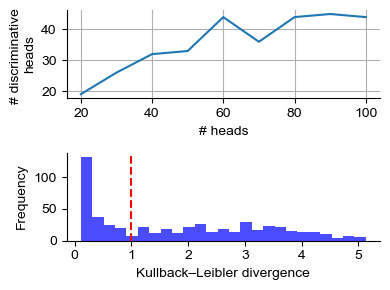

In [4]:
kl_pcts = [1, 2, 5, 10, 20, 50]
kl_thresholds = []
for kl_pct in kl_pcts:
    kl_threshold = sp.stats.entropy([1] * kl_pct + [0] * (100 - kl_pct), [1] * 100)
    kl_thresholds.append(kl_threshold)

center_kl_df = pd.DataFrame(center_kl, index=Hs).T
local_kl_df = pd.DataFrame(local_kl, index=Hs).T
global_kl_df = pd.DataFrame(global_kl, index=Hs).T

fig, axes = plt.subplots(2, 1, figsize=(4, 3))

plt.sca(axes[0])
kl_pct = 50
kl_threshold = 1
((local_kl_df > kl_threshold).sum(axis=0)).plot()   
plt.xlabel('# heads')
plt.ylabel('# discriminative \nheads')
plt.grid()

plt.sca(axes[1])
plt.hist(local_kl_df.to_numpy().flatten(), bins=25, color='blue', alpha=0.7)
plt.axvline(1, color='red', ls='--')
plt.xlabel('Kullback–Leibler divergence')
plt.ylabel('Frequency')

plt.tight_layout()

for ax in axes:
    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)

fig.savefig('figures/slide_tags_h_kl.pdf', bbox_inches='tight')
local_kl_df.to_csv('saved_results/slide_tags_h_local_kl.csv')